# Metal oxide sunscreen


Note: the cost of running the entire notebook is larger than 1 FlexCredits.

Sunscreen technology, developed in the 1940s to mitigate sunburn, has advanced significantly with the integration of metal oxide particles, primarily zinc oxide and titanium dioxide. These formulations provide robust protection against UV rays, ensuring effective defense against varying intensities of sun exposure. A common misconception is that the protective action mainly arises from the reflection and scattering of these active metal oxide particles, rather than their absorption.

In this notebook, we will reproduce the results presented in the paper titled: `Cole, C., Shyr, T., & Ou‐Yang, H. (2015). Metal oxide sunscreens protect skin by absorption, not by reflection or scattering` [https://doi.org/10.1111/phpp.12214](https://onlinelibrary.wiley.com/doi/10.1111/phpp.12214), where the authors confirmed, through absorption and reflectance measurements, that the main mechanism underlying UV block in metal oxide particle-based sunscreen relies on absorption of the particles, rather than reflection or scattering.


The simulation model consists of an agglomerate of TiO₂ nanoparticles excited by a plane wave at normal incidence. Flux monitors are positioned on the top and bottom of the simulation domain to compute transmitted and forward scattered fields (which would penetrate the skin) and reflected and back-scattered fields (which do not penetrate the skin due to the nanoparticles action). The material properties of the TiO₂ particles are obtained directly from [refractiveindex.info](https://refractiveindex.info/), and fitted using `Tidy3D`'s dispersion fitting tool.


<img src="img/MetalOxideSunscreen_1.png" width="800" alt="Schematic of the experiment">

For more examples involving scattering of nanoparticles and structured surfaces, please refer to our [example library](https://www.flexcompute.com/tidy3d/learning-center/example-library/), where you can find interesting case studies such as [scattering cross-section calculation of a dielectric sphere](https://www.flexcompute.com/tidy3d/examples/notebooks/Near2FarSphereRCS/), [the scattering of a plasmonic nanoparticle ](https://www.flexcompute.com/tidy3d/examples/notebooks/PlasmonicNanoparticle/), [the gradient metasurface reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GradientMetasurfaceReflector/), and [the dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/).


## Simulation Setup

First, we will import the necessary libraries.

In [1]:
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt
from tidy3d import web

# defining a random seed for reproducibility
np.random.seed(12)

### Retrieving refractive index data and creating the medium.

We will retrieve material property data from [refractiveindex.info](https://refractiveindex.info/) using the `from_url` method of the [`FastDispersionFitter`](https://docs.flexcompute.com/projects/tidy3d/en/v2.5.2/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) class, and fit a pole residue medium. 

For more information about fitting dispersive material, please refer to this example [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Fitting/).

In [2]:
from tidy3d.plugins.dispersion import FastDispersionFitter

url = 'https://refractiveindex.info/tmp/database/data-nk/main/TiO2/Zhukovsky.txt'

# creating the fitter object loading that from the url
fitter = FastDispersionFitter.from_url(url,delimiter= '\t')

# fitting the data
medium, error = fitter.fit(max_num_poles=5)

Output()

12:17:24 -03 WARNING: Unable to fit with weighted RMS error under               
             'tolerance_rms' of 1e-05                                           

Although the RMS error cannot be below $10^{-5}$, we can see that the material properties are well described by the fit.

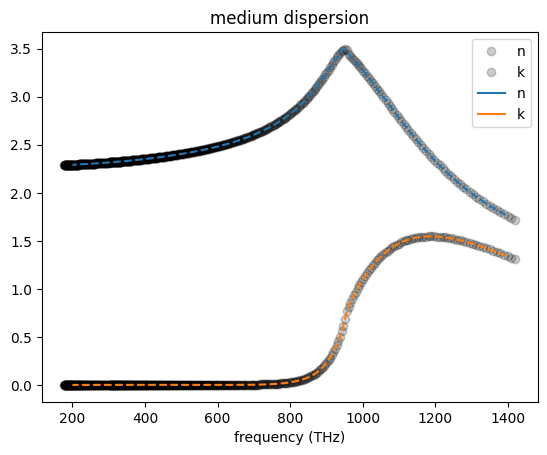

In [3]:
# plotting for comparison
fig, ax = plt.subplots()

# original dataset
freq = td.C_0 / fitter.wvl_um * 10**-12
ax.plot(freq, fitter.n_data, 'o', alpha=0.2, color="black", label = 'n')
ax.plot(freq, fitter.k_data, 'o', alpha=0.2, color="black", label = 'k')


medium.plot(np.linspace(td.C_0 / 0.215, td.C_0 / 1.5, 1000), ax=ax)
ax.lines[-1].set_ls("--")
ax.lines[-1].set_label('Fitted n')
ax.lines[-2].set_ls("--")
ax.lines[-2].set_label('Fitted k')

### Define parameters for building the simulation

We are now defining the parameters that will be used to build the simulation.

In [4]:
# for simplicity, the nanoparticles are modeled as spheres
size = 0.025

# volume to place the nanoparticles
lx = 1.2
ly = 1.2
lz = 10 * size

# target spectrum
wl1 = 0.22
wl2 = 0.800

central_wl = (wl2 - wl1) / 2 + wl1
freq1 = td.C_0 / wl1
freq2 = td.C_0 / wl2
freq0 = (freq1 - freq2) / 2 + freq2
fwidth = (freq1 - freq2) / 2

# frequencies to be analyzed in the monitors
freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 1000)

# size of the simulation domain
Lz = 2 * wl2 + lz
Lx = lx
Ly = ly

# souce and monitor position
monitor_z = (Lz / 2 - lz / 2) / 3
source_z = -Lz / 2 + 2 * (Lz / 2 - lz / 2) / 3

structures_center = (0, 0, 0)

# simulation runtime
run_time = 5e-12

# boundary specifications. We will define PML at the z-boundaries and periodic conditions on the remaining ones."
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
)

Now we will create an auxiliary function to randomly place the nanoparticles as a function of the concentration. The number of particles is calculated with parameters given in the paper.

In [5]:
def get_particles(proportion=0.2):
    # concentration of petrolatum matrix
    petrolatum_concentration = 1.3e-8  # mg/um^3
    active_proportion = proportion
    particle_volume = (4 / 3) * np.pi * size**3
    Ti02_density = 4.23e-9  # mg/um^3
    particle_weight = Ti02_density * particle_volume

    # calculate the total mass of Ti02 nanoparticles
    volume = lx * ly * lz
    Ti02_mass = active_proportion * volume * petrolatum_concentration  # mg

    # defining the number of particles
    N_particles = int(Ti02_mass / particle_weight)

    # create arrays of random positions for each particle
    positions_x = np.random.uniform(-lx / 2, lx / 2, N_particles)
    position_y = np.random.uniform(-ly / 2, ly / 2, N_particles)
    positions_z = np.random.uniform(
        structures_center[2] - lz / 2, structures_center[2] + lz / 2, N_particles
    )

    # create a first geometry object and sum the others to form the agglomerate
    particles = td.Sphere(
        center=(positions_x[0], position_y[0], positions_z[0]), radius=size
    )

    for pos in zip(positions_x[1:], position_y[1:], positions_z[1:]):
        particles += td.Sphere(center=pos, radius=size)

    particles = td.Structure(geometry=particles, medium=medium)

    return [particles]

Define source and monitors:

The source spectrum is chosen to cover the most intense part of the solar emission and the UV region, which is the main concern for skin health.

Since the size of the nanoparticles is much smaller than the target wavelengths, 
we will add a [mesh override structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MeshOverrideStructure.html) 
to properly resolve the nanoparticles agglomerate.

We will simulate for two active particle concentration, 10% and 20%.


In [6]:
source = td.PlaneWave(
    center=(0, 0, source_z),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
)

monitor_bottom = td.FluxMonitor(
        center=(0, 0, -Lz / 2 + monitor_z),
        size=(td.inf, td.inf, 0),
        freqs=freqs,
        name="z-",
    )

monitor_top = td.FluxMonitor(
        center=(0, 0, Lz / 2 - monitor_z),
        size=(td.inf, td.inf, 0),
        freqs=freqs,
        name="z",
    )



mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=structures_center, size=(lx, ly, lz + 2 * size)),
    dl=(size / 6,) * 3,
)
grid_spec = td.GridSpec.auto(min_steps_per_wvl=10, override_structures=[mesh_override])

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    structures=[],
    sources=[source],
    monitors=[monitor_bottom,monitor_top],
    run_time=run_time,
    boundary_spec=boundary_spec,
    grid_spec=grid_spec,
)

Simulations = {
    "proportion 10%": sim.updated_copy(structures=get_particles(0.1)),
    "proportion 20%": sim.updated_copy(structures=get_particles(0.2)),
}

# visualizing
Simulations["proportion 10%"].plot_3d()

We will run both simulations in parallel using the [`web.Batch`](https://docs.flexcompute.com/projects/tidy3d/en/v1.5.0/_autosummary/tidy3d.web.container.Batch.html) function.

In [7]:
batch = web.Batch(simulations=Simulations, verbose=True)
results = batch.run(path_dir="batch_simulations")

Output()

12:17:39 -03 Started working on Batch containing 2 tasks.

12:17:42 -03 Maximum FlexCredit cost: 14.937 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

12:18:44 -03 Batch complete.

Output()

We will organize the data in a pandas `DataFrame` object.

The transmitted flux is defined as the flux in the upper monitor, the reflected flux as the flux in the bottom monitor, and the absorbed flux will be defined as $A = 1 - (T + R)$

In [8]:
import pandas as pd

df = pd.DataFrame(
    index=td.C_0 / freqs,
    columns=[
        "Transmitted 10%",
        "Reflected 10%",
        "Absorbed 10%",
        "Transmitted 20%",
        "Reflected 20%",
        "Absorbed 20%",
    ],
)

for sim in ["proportion 10%", "proportion 20%"]:
    sim_data = results[sim]

    T = sim_data["z"].flux
    R = abs(sim_data["z-"].flux)
    A = 1 - (T + R)

    df["Transmitted %s" % sim.split()[-1]] = T
    df["Reflected %s" % sim.split()[-1]] = R
    df["Absorbed %s" % sim.split()[-1]] = A

df.head(10)

,Transmitted 10%,Reflected 10%,Absorbed 10%,Transmitted 20%,Reflected 20%,Absorbed 20%
0.800000,0.969677,0.046212,-0.015889,0.921638,0.017291,0.061071
0.797894,0.969730,0.045390,-0.015120,0.922198,0.016671,0.061131
0.795800,0.969793,0.044534,-0.014327,0.922825,0.016071,0.061104
0.793716,0.969888,0.043687,-0.013575,0.923352,0.015560,0.061088
0.791643,0.969990,0.042879,-0.012869,0.923519,0.015133,0.061348
0.789581,0.970064,0.042090,-0.012154,0.923602,0.014807,0.061592
0.787530,0.970105,0.041276,-0.011380,0.923368,0.014583,0.062049
0.785490,0.970146,0.040430,-0.010576,0.922945,0.014432,0.062623
0.783460,0.970217,0.039589,-0.009806,0.922452,0.014377,0.063172
0.781440,0.970310,0.038785,-0.009095,0.921654,0.014391,0.063955


Plotting the results, we can see the transmittance follows a similar behavior as reported for the TiO₂ < 25 nm nanoparticles in Figure 2 of the [paper](https://onlinelibrary.wiley.com/doi/10.1111/phpp.12214).

Looking at the proportion of reflected light, we can conclude that the main mechanism of UV blocking is indeed the absorption of the nanoparticles.

It is interesting to note the complete blockage in the UVB region (280 - 315 nm) and significant attenuation in the UVA region (315 - 400 nm), especially for the 0.2% proportion, primarily due to absorption.

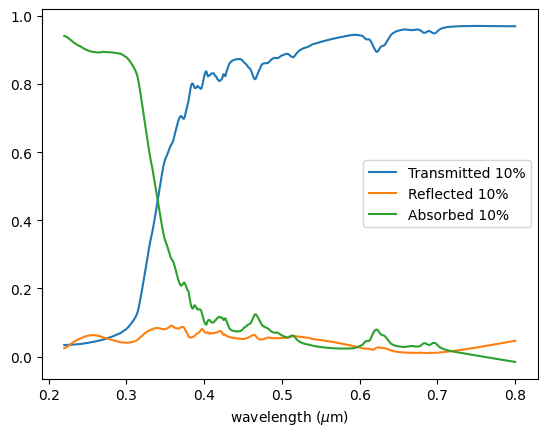

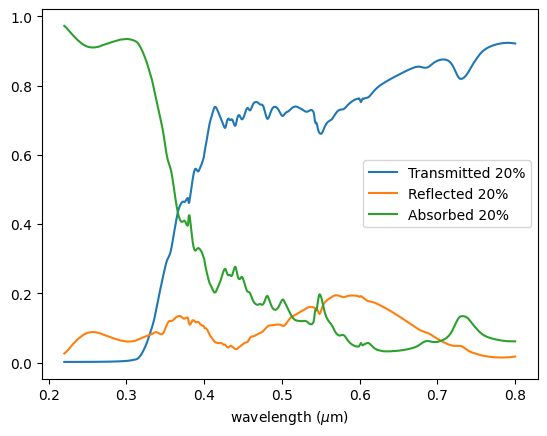

Proportion of scattered light at 10%: 0.05
Proportion of scattered light at 20%: 0.09


In [9]:
fig, ax = plt.subplots()
ax = df["Transmitted 10%"].plot()
ax = df["Reflected 10%"].plot(ax=ax)
ax = df["Absorbed 10%"].plot(ax=ax)
ax.set_xlabel('wavelength ($\mu$m)')
ax.legend()

fig, ax = plt.subplots()
ax = df["Transmitted 20%"].plot()
ax = df["Reflected 20%"].plot(ax=ax)
ax = df["Absorbed 20%"].plot(ax=ax)
ax.set_xlabel('wavelength ($\mu$m)')
ax.legend()

plt.show()

print(
    "Proportion of scattered light at 10%s: %.2f" % ("%", df["Reflected 10%"].mean())
)
print(
    "Proportion of scattered light at 20%s: %.2f" % ("%", df["Reflected 20%"].mean())
)